In [1]:
import os
import random

import pandas as pd
import torch
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import pickle

In [2]:
data_dir = '/opt/ml/input/data/train/images'
profiles = os.listdir(data_dir)
profiles = [profile for profile in profiles if not profile.startswith(".")]

In [5]:
with open('split_profiles_seed32.pickle', 'rb') as fr:
   split_profiles = pickle.load(fr)
train_idx= split_profiles['train']
val_idx= split_profiles['val']

In [6]:
print(len(train_idx))
print(len(val_idx))

2213
487


train 과 validation dataframe 만들기

In [7]:
class MaskLabels(int):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2
    
_file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

for phase, indices in split_profiles.items():
    image_paths=[]
    mask_labels=[]
    gender_labels=[]
    age_labels=[]
    ids=[]
    
    for _idx in indices:
        profile = profiles[_idx]
        img_folder = os.path.join(data_dir, profile)
        for file_name in os.listdir(img_folder):
            _file_name, ext = os.path.splitext(file_name)
            if _file_name not in _file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                continue

            img_path = os.path.join(data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
            mask_label = _file_names[_file_name]

            idd, gender, race, age = profile.split("_")
#             gender_label = GenderLabels.from_str(gender)
#             age_label = AgeLabels.from_number(age)

            ids.append(idd)
            image_paths.append(img_path)
            mask_labels.append(mask_label)
            gender_labels.append(gender)
            age_labels.append(age)

    if phase == 'train':
        train_df= pd.DataFrame({'ids':ids,'image_paths':image_paths, 'mask_labels':mask_labels, 'gender_labels':gender_labels,'age_labels':age_labels})
    elif phase == 'val':
        val_df= pd.DataFrame({'ids':ids,'image_paths':image_paths, 'mask_labels':mask_labels, 'gender_labels':gender_labels,'age_labels':age_labels})

In [8]:
train_df

,ids,image_paths,mask_labels,gender_labels,age_labels
0,003130,/opt/ml/input/data/train/images/003130_female_...,0,female,19
1,003130,/opt/ml/input/data/train/images/003130_female_...,2,female,19
2,003130,/opt/ml/input/data/train/images/003130_female_...,0,female,19
3,003130,/opt/ml/input/data/train/images/003130_female_...,0,female,19
4,003130,/opt/ml/input/data/train/images/003130_female_...,1,female,19
...,...,...,...,...,...
15486,005523,/opt/ml/input/data/train/images/005523_male_As...,0,male,52
15487,005523,/opt/ml/input/data/train/images/005523_male_As...,0,male,52
15488,005523,/opt/ml/input/data/train/images/005523_male_As...,1,male,52
15489,005523,/opt/ml/input/data/train/images/005523_male_As...,0,male,52


In [9]:
val_df

,ids,image_paths,mask_labels,gender_labels,age_labels
0,003061,/opt/ml/input/data/train/images/003061_female_...,0,female,20
1,003061,/opt/ml/input/data/train/images/003061_female_...,2,female,20
2,003061,/opt/ml/input/data/train/images/003061_female_...,0,female,20
3,003061,/opt/ml/input/data/train/images/003061_female_...,0,female,20
4,003061,/opt/ml/input/data/train/images/003061_female_...,1,female,20
...,...,...,...,...,...
3404,001534,/opt/ml/input/data/train/images/001534_male_As...,0,male,20
3405,001534,/opt/ml/input/data/train/images/001534_male_As...,0,male,20
3406,001534,/opt/ml/input/data/train/images/001534_male_As...,1,male,20
3407,001534,/opt/ml/input/data/train/images/001534_male_As...,0,male,20


In [10]:
train_df.age_labels= train_df.age_labels.apply(int)

# 60세 이상인 사람들만 증강

<AxesSubplot:xlabel='age_labels', ylabel='Density'>

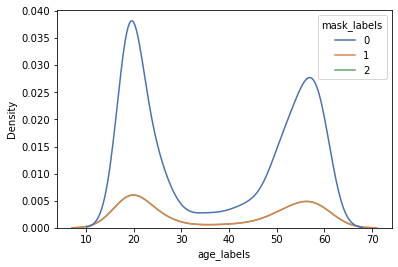

In [11]:
# mask label 별로 age labels 시각화
pal= sns.color_palette('deep',3)
sns.kdeplot(data=train_df, x=train_df.age_labels, hue= train_df.mask_labels, palette=pal)

- 마스크 쓴 사람 > 이상하게 쓴 사람 > 안쓴사람
- 60세 이상+안쓴사람 이 제일 수가 적고 분류도 가장 못하기 때문에 60세 이상 + 마스크 안쓴 사람의 이미지를 늘리자 -> loss가 더 늘어남

In [15]:
# 마스크 안쓴사람
normal= train_df[train_df.mask_labels  == 2]
print(len(normal))


# 마스크 쓴사람
wear= train_df[train_df.mask_labels  == 0]
print(len(wear))


# 마스크 이상하게 쓴사람
incorrect= train_df[train_df.mask_labels  == 1]
print(len(incorrect))

2213
11065
2213


In [17]:
# 60세 이상인 사람 
normal_old= normal[normal.age_labels >= 60]
print(len(normal_old))
wear_old= wear[wear.age_labels >= 60]
print(len(wear_old))
incorrect_old= incorrect[incorrect.age_labels >= 60]
print(len(incorrect_old))

156
780
156


In [19]:
# 30-60세인 사람
normal_mid= normal[normal.age_labels >= 30]
normal_mid= normal_mid[normal_mid.age_labels < 60]
print(len(normal_mid))

wear_mid= wear[wear.age_labels >= 30]
wear_mid= wear[wear.age_labels < 60]
print(len(wear_mid))

incorrect_mid= incorrect[incorrect.age_labels >= 30]
incorrect_mid= incorrect[incorrect.age_labels < 60]
print(len(incorrect_mid))

1015
10285
2057


<AxesSubplot:xlabel='age_labels', ylabel='Count'>

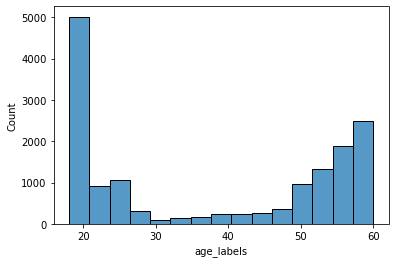

In [36]:
sns.histplot(data=train_df, x=train_df.age_labels,  palette=pal)

In [21]:
normal_young= normal[normal.age_labels < 30]
print(len(normal_young))
normal_mid= normal[normal.age_labels >= 30]
normal_mid= normal_mid[normal_mid.age_labels < 60]
print(len(normal_mid))

1042
1015


In [22]:
normal_old= normal[normal.age_labels >= 60]
print(len(normal_old))
normal_old.head()

156


,ids,image_paths,mask_labels,gender_labels,age_labels
15,001382,/opt/ml/input/data/train/images/001382_female_...,2,female,60
176,004354,/opt/ml/input/data/train/images/004354_male_As...,2,male,60
568,004312,/opt/ml/input/data/train/images/004312_female_...,2,female,60
701,003837,/opt/ml/input/data/train/images/003837_male_As...,2,male,60
1079,003528,/opt/ml/input/data/train/images/003528_male_As...,2,male,60


In [23]:
normal_old.groupby('age_labels').count()

,ids,image_paths,mask_labels,gender_labels
age_labels,,,,
60,156,156,156,156


- 60세 이상인 사람들의 나이는 모두 60세이다. 
- normal_old를 6배 늘려보자 -> 972개로
- 한 이미지 당 6개 추가로 생성 -> 60세 이상인 이미지 폴더 당 마스크 안쓴 사람의 사진이 총 7장

# Old Augmentation

In [24]:
# import shutil

# shutil.copytree("/opt/ml/input/data/train/images", "/opt/ml/input/data/train/images2")

'/opt/ml/input/data/train/images2'

In [25]:
normal_old_idx= list(normal_old.index)
print(len(normal_old_idx))
wear_old_idx= list(wear_old.index)
print(len(wear_old_idx))
incorrect_old_idx= list(incorrect_old.index)
print(len(incorrect_old_idx))

156
780
156


In [26]:
from albumentations import *

In [27]:
transform = Compose([
    CenterCrop(height=256, width=192, p=0.5),
    ColorJitter(p=0.9),
    HorizontalFlip(p=0.7),
    GaussNoise(p=0.9),
    RandomBrightnessContrast(brightness_limit=(-0.4, 0.4), contrast_limit=(-0.4, 0.4),p=0.9),
    HueSaturationValue(p=0.9),
    Resize(512, 384,p=1)
], p=1.0)

In [28]:
def make_new_image(num:int, img, idd:str, gender: str, mask: str, age: int):
    output_dir= '/opt/ml/input/data/train/images2'
    if mask ==0:
        state= 'mask'
    elif mask == 1: 
        state= 'incorrect_mask'
    else:
        state= 'normal'
        
    name = idd+'_'+gender+f'_Asian_{age}/{state}_{num}.jpg'

    path = os.path.join(output_dir, name)
    img.save(path)
  
    return {"ids":idd, "image_paths": path,  "mask_labels":mask, "gender_labels":gender,"age_labels":age}

In [29]:
new_df= pd.DataFrame()
amount=0
for idx in normal_old_idx:
    for i in range(6):
        amount+=1
        image= transform(image= np.array(Image.open(normal_old['image_paths'][idx])))['image']
        image= Image.fromarray(image,'RGB')
        data=make_new_image(num= i, img=image, idd=normal_old['ids'][idx], gender=normal_old['gender_labels'][idx], mask=normal_old['mask_labels'][idx], age=60)
        new_df= new_df.append(data, ignore_index=True)
print(f'save normal_old_image {amount}')

amount=0
for idx in wear_old_idx:
    for i in range(1):
        amount+=1
        image= transform(image= np.array(Image.open(wear_old['image_paths'][idx])))['image']
        image= Image.fromarray(image,'RGB')
        data=make_new_image(num= i, img=image, idd= wear_old['ids'][idx], gender= wear_old['gender_labels'][idx], mask= wear_old['mask_labels'][idx], age= 60)
        new_df= new_df.append(data, ignore_index=True)
        print(f'save image {amount}')
print(f'save wear_old_image {amount}')

amount=0
for idx in incorrect_old_idx:
    for i in range(6):
        amount+=1
        image= transform(image= np.array(Image.open(incorrect_old['image_paths'][idx])))['image']
        image= Image.fromarray(image,'RGB')
        data=make_new_image(num= i, img=image, idd= incorrect_old['ids'][idx], gender= incorrect_old['gender_labels'][idx], mask=incorrect_old['mask_labels'][idx], age= 60)
        new_df= new_df.append(data, ignore_index=True)
        print(f'save image {amount}')
print(f'save incorrect_old_image {amount}')

/tmp/ipykernel_24298/253161635.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

save normal_old_image 936
save image 1
save image 2
save image 3
save image 4
save image 5


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 6
save image 7
save image 8
save image 9


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 10
save image 11
save image 12
save image 13
save image 14


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 15
save image 16
save image 17
save image 18
save image 19


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 20
save image 21
save image 22
save image 23
save image 24


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 25
save image 26
save image 27
save image 28
save image 29


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 30
save image 31
save image 32
save image 33
save image 34


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 35
save image 36
save image 37
save image 38
save image 39
save image 40
save image 41


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 42
save image 43
save image 44
save image 45
save image 46


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 47
save image 48
save image 49
save image 50
save image 51


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 52
save image 53
save image 54
save image 55


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 56
save image 57
save image 58
save image 59


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 60
save image 61
save image 62
save image 63
save image 64
save image 65


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 66
save image 67
save image 68
save image 69
save image 70


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 71
save image 72
save image 73
save image 74
save image 75


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 76
save image 77
save image 78
save image 79
save image 80


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 81
save image 82
save image 83
save image 84
save image 85


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 86
save image 87
save image 88
save image 89
save image 90
save image 91


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 92
save image 93
save image 94
save image 95
save image 96
save image 97


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 98
save image 99
save image 100
save image 101


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 102
save image 103
save image 104
save image 105
save image 106


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 107
save image 108
save image 109
save image 110
save image 111


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 112
save image 113
save image 114
save image 115
save image 116


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 117
save image 118
save image 119
save image 120


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 121
save image 122
save image 123
save image 124
save image 125


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 126
save image 127
save image 128
save image 129
save image 130


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 131
save image 132
save image 133
save image 134


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 135
save image 136
save image 137
save image 138
save image 139


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 140
save image 141
save image 142
save image 143


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 144
save image 145
save image 146
save image 147


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 148
save image 149
save image 150
save image 151
save image 152
save image 153


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 154
save image 155
save image 156
save image 157
save image 158


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 159
save image 160
save image 161
save image 162
save image 163


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 164
save image 165
save image 166
save image 167
save image 168
save image 169


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 170
save image 171
save image 172
save image 173
save image 174
save image 175


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 176
save image 177
save image 178
save image 179
save image 180


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 181
save image 182
save image 183
save image 184
save image 185
save image 186


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 187
save image 188
save image 189
save image 190
save image 191
save image 192


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 193
save image 194
save image 195
save image 196
save image 197
save image 198


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 199
save image 200
save image 201
save image 202
save image 203


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 204
save image 205
save image 206
save image 207
save image 208
save image 209


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 210
save image 211
save image 212
save image 213
save image 214


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 215
save image 216
save image 217
save image 218


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 219
save image 220
save image 221
save image 222
save image 223


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 224
save image 225
save image 226
save image 227
save image 228


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 229
save image 230
save image 231
save image 232
save image 233


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 234
save image 235
save image 236
save image 237
save image 238
save image 239
save image 240


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 241
save image 242
save image 243
save image 244


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 245
save image 246
save image 247
save image 248
save image 249


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 250
save image 251
save image 252
save image 253
save image 254
save image 255


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 256
save image 257
save image 258
save image 259


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 260
save image 261
save image 262
save image 263


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 264
save image 265
save image 266
save image 267
save image 268


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 269
save image 270
save image 271
save image 272
save image 273


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 274
save image 275
save image 276
save image 277


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 278
save image 279
save image 280
save image 281
save image 282


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 283
save image 284
save image 285
save image 286


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 287
save image 288
save image 289
save image 290
save image 291
save image 292


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 293
save image 294
save image 295
save image 296
save image 297
save image 298


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 299
save image 300
save image 301
save image 302
save image 303
save image 304


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 305
save image 306
save image 307
save image 308
save image 309


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 310
save image 311
save image 312
save image 313
save image 314
save image 315


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 316
save image 317
save image 318
save image 319
save image 320


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 321
save image 322
save image 323
save image 324


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 325
save image 326
save image 327
save image 328
save image 329


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 330
save image 331
save image 332
save image 333
save image 334


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 335
save image 336
save image 337
save image 338
save image 339


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 340
save image 341
save image 342
save image 343
save image 344


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 345
save image 346
save image 347
save image 348
save image 349


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 350
save image 351
save image 352
save image 353
save image 354


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 355
save image 356
save image 357
save image 358
save image 359


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 360
save image 361
save image 362
save image 363
save image 364


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 365
save image 366
save image 367
save image 368
save image 369


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 370
save image 371
save image 372
save image 373
save image 374
save image 375


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 376
save image 377
save image 378
save image 379


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 380
save image 381
save image 382
save image 383
save image 384


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 385
save image 386
save image 387
save image 388
save image 389
save image 390


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 391
save image 392
save image 393
save image 394


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 395
save image 396
save image 397
save image 398
save image 399
save image 400


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 401
save image 402
save image 403
save image 404
save image 405
save image 406


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 407
save image 408
save image 409
save image 410
save image 411


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 412
save image 413
save image 414
save image 415
save image 416
save image 417


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 418
save image 419
save image 420
save image 421
save image 422


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 423
save image 424
save image 425
save image 426
save image 427


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 428
save image 429
save image 430
save image 431
save image 432


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 433
save image 434
save image 435
save image 436
save image 437


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 438
save image 439
save image 440
save image 441


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 442
save image 443
save image 444
save image 445
save image 446


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 447
save image 448
save image 449
save image 450
save image 451


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 452
save image 453
save image 454
save image 455
save image 456
save image 457


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 458
save image 459
save image 460
save image 461


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 462
save image 463
save image 464
save image 465
save image 466


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 467
save image 468
save image 469
save image 470
save image 471


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 472
save image 473
save image 474
save image 475
save image 476


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 477
save image 478
save image 479
save image 480
save image 481


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 482
save image 483
save image 484
save image 485


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 486
save image 487
save image 488
save image 489
save image 490


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 491
save image 492
save image 493
save image 494
save image 495
save image 496


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 497
save image 498
save image 499
save image 500
save image 501
save image 502


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 503
save image 504
save image 505
save image 506
save image 507
save image 508


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 509
save image 510
save image 511
save image 512


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 513
save image 514
save image 515
save image 516
save image 517


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 518
save image 519
save image 520
save image 521


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 522
save image 523
save image 524
save image 525
save image 526
save image 527


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 528
save image 529
save image 530
save image 531
save image 532


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 533
save image 534
save image 535
save image 536
save image 537
save image 538
save image 539


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 540
save image 541
save image 542
save image 543
save image 544


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 545
save image 546
save image 547
save image 548


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 549
save image 550
save image 551
save image 552


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 553
save image 554
save image 555
save image 556
save image 557


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 558
save image 559
save image 560
save image 561
save image 562


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 563
save image 564
save image 565
save image 566
save image 567


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 568
save image 569
save image 570
save image 571


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 572
save image 573
save image 574
save image 575
save image 576
save image 577


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 578
save image 579
save image 580
save image 581
save image 582
save image 583


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 584
save image 585
save image 586
save image 587
save image 588


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 589
save image 590
save image 591
save image 592


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 593
save image 594
save image 595
save image 596
save image 597
save image 598


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 599
save image 600
save image 601
save image 602
save image 603


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 604
save image 605
save image 606
save image 607
save image 608
save image 609
save image 610


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 611
save image 612
save image 613
save image 614


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 615
save image 616
save image 617
save image 618


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 619
save image 620
save image 621
save image 622


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 623
save image 624
save image 625
save image 626
save image 627


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 628
save image 629
save image 630
save image 631
save image 632


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 633
save image 634
save image 635
save image 636


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 637
save image 638
save image 639
save image 640
save image 641
save image 642


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 643
save image 644
save image 645
save image 646
save image 647


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 648
save image 649
save image 650
save image 651
save image 652


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 653
save image 654
save image 655
save image 656
save image 657


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 658
save image 659
save image 660
save image 661
save image 662


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 663
save image 664
save image 665
save image 666


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 667
save image 668
save image 669
save image 670
save image 671


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 672
save image 673
save image 674
save image 675
save image 676


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 677
save image 678
save image 679
save image 680
save image 681
save image 682


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 683
save image 684
save image 685
save image 686
save image 687


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 688
save image 689
save image 690
save image 691


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 692
save image 693
save image 694
save image 695
save image 696
save image 697


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 698
save image 699
save image 700
save image 701


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 702
save image 703
save image 704
save image 705
save image 706
save image 707


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 708
save image 709
save image 710
save image 711
save image 712


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 713
save image 714
save image 715
save image 716
save image 717


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 718
save image 719
save image 720
save image 721
save image 722
save image 723


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 724
save image 725
save image 726
save image 727
save image 728
save image 729


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 730
save image 731
save image 732
save image 733
save image 734
save image 735


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 736
save image 737
save image 738
save image 739
save image 740


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 741
save image 742
save image 743
save image 744
save image 745
save image 746


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 747
save image 748
save image 749
save image 750
save image 751


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 752
save image 753
save image 754
save image 755
save image 756
save image 757


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 758
save image 759
save image 760
save image 761


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 762
save image 763
save image 764
save image 765


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 766
save image 767
save image 768
save image 769
save image 770


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 771
save image 772
save image 773
save image 774
save image 775
save image 776


/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 777
save image 778
save image 779
save image 780
save wear_old_image 780
save image 1


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 2
save image 3
save image 4
save image 5
save image 6


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 7
save image 8
save image 9
save image 10
save image 11


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 12
save image 13
save image 14
save image 15
save image 16


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 17
save image 18
save image 19
save image 20


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 21
save image 22
save image 23
save image 24
save image 25


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 26
save image 27
save image 28
save image 29
save image 30


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 31
save image 32
save image 33
save image 34
save image 35


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 36
save image 37
save image 38
save image 39
save image 40


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 41
save image 42
save image 43
save image 44
save image 45


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 46
save image 47
save image 48
save image 49
save image 50


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 51
save image 52
save image 53
save image 54


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 55
save image 56
save image 57
save image 58


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 59
save image 60
save image 61
save image 62
save image 63


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 64
save image 65
save image 66
save image 67
save image 68
save image 69


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 70
save image 71
save image 72
save image 73


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 74
save image 75
save image 76
save image 77
save image 78


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 79
save image 80
save image 81
save image 82
save image 83
save image 84
save image 85


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 86
save image 87
save image 88
save image 89
save image 90


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 91
save image 92
save image 93
save image 94


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 95
save image 96
save image 97
save image 98
save image 99


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 100
save image 101
save image 102
save image 103


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 104
save image 105
save image 106
save image 107


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 108
save image 109
save image 110
save image 111
save image 112


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 113
save image 114
save image 115
save image 116
save image 117


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 118
save image 119
save image 120
save image 121
save image 122


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 123
save image 124
save image 125
save image 126
save image 127


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 128
save image 129
save image 130
save image 131
save image 132
save image 133
save image 134


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 135
save image 136
save image 137
save image 138


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 139
save image 140
save image 141
save image 142


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 143
save image 144
save image 145
save image 146
save image 147


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 148
save image 149
save image 150
save image 151
save image 152
save image 153


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 154
save image 155
save image 156
save image 157
save image 158
save image 159


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 160
save image 161
save image 162
save image 163
save image 164
save image 165


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 166
save image 167
save image 168
save image 169
save image 170


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 171
save image 172
save image 173
save image 174
save image 175


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 176
save image 177
save image 178
save image 179
save image 180
save image 181


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 182
save image 183
save image 184
save image 185


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 186
save image 187
save image 188
save image 189
save image 190


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 191
save image 192
save image 193
save image 194
save image 195
save image 196


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 197
save image 198
save image 199
save image 200
save image 201


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 202
save image 203
save image 204
save image 205
save image 206


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 207
save image 208
save image 209
save image 210
save image 211


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 212
save image 213
save image 214
save image 215
save image 216


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 217
save image 218
save image 219
save image 220
save image 221


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 222
save image 223
save image 224
save image 225
save image 226


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 227
save image 228
save image 229
save image 230
save image 231


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 232
save image 233
save image 234
save image 235


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 236
save image 237
save image 238
save image 239
save image 240
save image 241


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 242
save image 243
save image 244
save image 245
save image 246
save image 247


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 248
save image 249
save image 250
save image 251
save image 252
save image 253


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 254
save image 255
save image 256
save image 257
save image 258


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 259
save image 260
save image 261
save image 262
save image 263


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 264
save image 265
save image 266
save image 267
save image 268


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 269
save image 270
save image 271
save image 272


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 273
save image 274
save image 275
save image 276
save image 277


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 278
save image 279
save image 280
save image 281
save image 282


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 283
save image 284
save image 285
save image 286
save image 287
save image 288


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 289
save image 290
save image 291
save image 292


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 293
save image 294
save image 295
save image 296
save image 297


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 298
save image 299
save image 300
save image 301


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 302
save image 303
save image 304
save image 305
save image 306


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 307
save image 308
save image 309
save image 310
save image 311
save image 312


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 313
save image 314
save image 315
save image 316


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 317
save image 318
save image 319
save image 320
save image 321


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 322
save image 323
save image 324
save image 325
save image 326


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 327
save image 328
save image 329
save image 330
save image 331


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 332
save image 333
save image 334
save image 335
save image 336


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 337
save image 338
save image 339
save image 340
save image 341


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 342
save image 343
save image 344
save image 345
save image 346


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 347
save image 348
save image 349
save image 350
save image 351
save image 352


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 353
save image 354
save image 355
save image 356
save image 357
save image 358


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 359
save image 360
save image 361
save image 362
save image 363


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 364
save image 365
save image 366
save image 367
save image 368


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 369
save image 370
save image 371
save image 372


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 373
save image 374
save image 375
save image 376
save image 377
save image 378


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 379
save image 380
save image 381
save image 382
save image 383
save image 384


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 385
save image 386
save image 387
save image 388
save image 389


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 390
save image 391
save image 392
save image 393
save image 394
save image 395


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 396
save image 397
save image 398
save image 399
save image 400
save image 401


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 402
save image 403
save image 404
save image 405


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 406
save image 407
save image 408
save image 409
save image 410


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 411
save image 412
save image 413
save image 414
save image 415
save image 416


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 417
save image 418
save image 419
save image 420


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 421
save image 422
save image 423
save image 424
save image 425


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 426
save image 427
save image 428
save image 429
save image 430


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 431
save image 432
save image 433
save image 434


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 435
save image 436
save image 437
save image 438
save image 439


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 440
save image 441
save image 442
save image 443


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 444
save image 445
save image 446
save image 447
save image 448


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 449
save image 450
save image 451
save image 452


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 453
save image 454
save image 455
save image 456


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 457
save image 458
save image 459
save image 460
save image 461


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 462
save image 463
save image 464
save image 465


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 466
save image 467
save image 468
save image 469


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 470
save image 471
save image 472
save image 473
save image 474


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 475
save image 476
save image 477
save image 478
save image 479


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 480
save image 481
save image 482
save image 483


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 484
save image 485
save image 486
save image 487


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 488
save image 489
save image 490
save image 491
save image 492


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 493
save image 494
save image 495
save image 496
save image 497


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 498
save image 499
save image 500
save image 501
save image 502


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 503
save image 504
save image 505
save image 506
save image 507


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 508
save image 509
save image 510
save image 511
save image 512


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 513
save image 514
save image 515
save image 516
save image 517
save image 518


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 519
save image 520
save image 521
save image 522
save image 523


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 524
save image 525
save image 526
save image 527
save image 528


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 529
save image 530
save image 531
save image 532


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 533
save image 534
save image 535
save image 536
save image 537


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 538
save image 539
save image 540
save image 541
save image 542


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 543
save image 544
save image 545
save image 546
save image 547
save image 548


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 549
save image 550
save image 551
save image 552
save image 553


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 554
save image 555
save image 556
save image 557


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 558
save image 559
save image 560
save image 561


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 562
save image 563
save image 564
save image 565
save image 566
save image 567


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 568
save image 569
save image 570
save image 571
save image 572


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 573
save image 574
save image 575
save image 576


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 577
save image 578
save image 579
save image 580
save image 581
save image 582


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 583
save image 584
save image 585
save image 586
save image 587


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 588
save image 589
save image 590
save image 591


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 592
save image 593
save image 594
save image 595
save image 596
save image 597


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 598
save image 599
save image 600
save image 601
save image 602
save image 603
save image 604


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 605
save image 606
save image 607
save image 608
save image 609
save image 610


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 611
save image 612
save image 613
save image 614
save image 615
save image 616


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 617
save image 618
save image 619
save image 620
save image 621
save image 622


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 623
save image 624
save image 625
save image 626
save image 627
save image 628


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 629
save image 630
save image 631
save image 632
save image 633
save image 634


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 635
save image 636
save image 637
save image 638
save image 639


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 640
save image 641
save image 642
save image 643


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 644
save image 645
save image 646
save image 647
save image 648


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 649
save image 650
save image 651
save image 652


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 653
save image 654
save image 655
save image 656


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 657
save image 658
save image 659
save image 660


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 661
save image 662
save image 663
save image 664


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 665
save image 666
save image 667
save image 668
save image 669
save image 670


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 671
save image 672
save image 673
save image 674


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 675
save image 676
save image 677
save image 678
save image 679


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 680
save image 681
save image 682
save image 683
save image 684


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 685
save image 686
save image 687
save image 688
save image 689


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 690
save image 691
save image 692
save image 693
save image 694
save image 695
save image 696


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 697
save image 698
save image 699
save image 700


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 701
save image 702
save image 703
save image 704


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 705
save image 706
save image 707
save image 708
save image 709


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 710
save image 711
save image 712
save image 713


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 714
save image 715
save image 716
save image 717
save image 718
save image 719


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 720
save image 721
save image 722
save image 723
save image 724


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 725
save image 726
save image 727
save image 728
save image 729


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 730
save image 731
save image 732
save image 733
save image 734
save image 735


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 736
save image 737
save image 738
save image 739
save image 740


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 741
save image 742
save image 743
save image 744


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 745
save image 746
save image 747
save image 748
save image 749
save image 750


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 751
save image 752
save image 753
save image 754
save image 755


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 756
save image 757
save image 758
save image 759
save image 760


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 761
save image 762
save image 763
save image 764
save image 765


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 766
save image 767
save image 768
save image 769
save image 770


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 771
save image 772
save image 773
save image 774
save image 775


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 776
save image 777
save image 778
save image 779
save image 780


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 781
save image 782
save image 783
save image 784
save image 785
save image 786


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 787
save image 788
save image 789
save image 790


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 791
save image 792
save image 793
save image 794


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 795
save image 796
save image 797
save image 798
save image 799
save image 800
save image 801


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 802
save image 803
save image 804
save image 805
save image 806
save image 807
save image 808


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 809
save image 810
save image 811
save image 812
save image 813
save image 814


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 815
save image 816
save image 817
save image 818
save image 819


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 820
save image 821
save image 822
save image 823


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 824
save image 825
save image 826
save image 827
save image 828


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 829
save image 830
save image 831
save image 832
save image 833


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 834
save image 835
save image 836
save image 837


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 838
save image 839
save image 840
save image 841


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 842
save image 843
save image 844
save image 845
save image 846


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 847
save image 848
save image 849
save image 850
save image 851


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 852
save image 853
save image 854
save image 855
save image 856
save image 857


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 858
save image 859
save image 860
save image 861
save image 862


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 863
save image 864
save image 865
save image 866
save image 867


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 868
save image 869
save image 870
save image 871
save image 872
save image 873
save image 874
save image 875
save image 876
save image 877
save image 878


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 879
save image 880
save image 881
save image 882


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 883
save image 884
save image 885
save image 886
save image 887


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 888
save image 889
save image 890
save image 891
save image 892


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 893
save image 894
save image 895
save image 896


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 897
save image 898
save image 899
save image 900
save image 901


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 902
save image 903
save image 904
save image 905
save image 906


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 907
save image 908
save image 909
save image 910
save image 911
save image 912


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 913
save image 914
save image 915
save image 916


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 917
save image 918
save image 919
save image 920
save image 921


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)


save image 922
save image 923
save image 924
save image 925


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

save image 926
save image 927
save image 928
save image 929
save image 930
save image 931
save image 932
save image 933
save image 934
save image 935
save image 936
save incorrect_old_image 936


/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df= new_df.append(data, ignore_index=True)
/tmp/ipykernel_24298/253161635.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pand

In [30]:
new_df

,ids,image_paths,mask_labels,gender_labels,age_labels
0,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
1,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
2,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
3,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
4,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
...,...,...,...,...,...
2647,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60
2648,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60
2649,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60
2650,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60


In [31]:
new_df[new_df.ids=='001382']

,ids,image_paths,mask_labels,gender_labels,age_labels
0,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
1,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
2,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
3,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
4,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
5,001382,/opt/ml/input/data/train/images2/001382_female...,2,female,60
936,001382,/opt/ml/input/data/train/images2/001382_female...,0,female,60
937,001382,/opt/ml/input/data/train/images2/001382_female...,0,female,60
938,001382,/opt/ml/input/data/train/images2/001382_female...,0,female,60
939,001382,/opt/ml/input/data/train/images2/001382_female...,0,female,60


In [32]:
new_train= pd.concat([train_df, new_df])
new_train.reset_index(inplace=True)

In [33]:
new_train

,index,ids,image_paths,mask_labels,gender_labels,age_labels
0,0,003130,/opt/ml/input/data/train/images/003130_female_...,0,female,19
1,1,003130,/opt/ml/input/data/train/images/003130_female_...,2,female,19
2,2,003130,/opt/ml/input/data/train/images/003130_female_...,0,female,19
3,3,003130,/opt/ml/input/data/train/images/003130_female_...,0,female,19
4,4,003130,/opt/ml/input/data/train/images/003130_female_...,1,female,19
...,...,...,...,...,...,...
18138,2647,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60
18139,2648,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60
18140,2649,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60
18141,2650,003729,/opt/ml/input/data/train/images2/003729_female...,1,female,60


<AxesSubplot:xlabel='age_labels', ylabel='Count'>

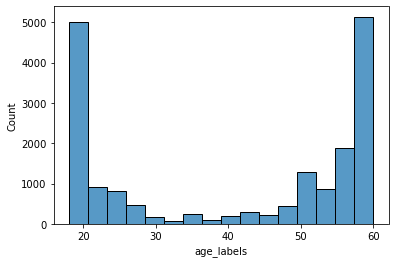

In [35]:
sns.histplot(data=new_train, x=new_train.age_labels,  palette=pal)

- 30미만인 라벨 0과 라벨 수가 비슷해짐

In [ ]:
# 마스크 안쓴사람
normal= train_df[train_df.mask_labels  == 2]
print(len(normal))


# 마스크 쓴사람
wear= train_df[train_df.mask_labels  == 0]
print(len(wear))


# 마스크 이상하게 쓴사람
incorrect= train_df[train_df.mask_labels  == 1]
print(len(incorrect))